# The Caring Home / Helpful Home Continued

A model that can look for non normal situations in a elderly person home, from smart home IoT sensors.

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [12]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [13]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [14]:
# We will use Ollama locally for some models so we will need requests
import requests

In [15]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['OPENROUTER_API_KEY'] = os.getenv('OPENROUTER_API_KEY', 'your-key-if-not-using-env')
os.environ['HYPERBOLIC_API_KEY'] = os.getenv('HYPERBOLIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [16]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [17]:
openai = OpenAI()
claude = Anthropic()

In [18]:
%matplotlib inline

In [19]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [20]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation"
    user_prompt = item.test_prompt().replace("\n\nResult is ","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Result is "}
    ]

In [22]:
# Try this out
#test[0].details
messages_for(test[0])

[{'role': 'system',
  'content': 'You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation'},
 {'role': 'user',
  'content': 'How would you classify this sensor data - normal or anomalous?\n\n[{"timestamp": 1709344800, "room": "bedroom", "nodeId": 2, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 1}}, "datetime": "Sat Mar 02 2024 02:00:00"}, {"timestamp": 1709345700, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1900}}, "datetime": "Sat Mar 02 2024 02:15:00"}, {"timestamp": 1709349300, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1900}}, "datetime": "Sat Mar 02 2024 03:15:00"}, {"timestamp": 1709352900, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1900}}, "datetime": "Sat Mar 02 2024 0

In [23]:
# A utility function to extract the result from a string

def get_result(text):
    # Match "normal" or "anomalous" anywhere in the text
    match = re.search(r"\b(normal|anomalous)\b", text, re.IGNORECASE)
    return match.group(1).lower() if match else None

In [24]:
get_result("The result is anomalous because blah blah")

'anomalous'

In [25]:
get_result("anomalous")

'anomalous'

In [26]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_result(reply)

In [27]:
test[0].result

'anomalous'

1: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709344800, "room": "bedr...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738072800, "room": "livi...
3: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1709413200, "room": "livi...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1740553200, "datetime": "...
5: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709247600, "room": "livi...
6: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1709294400, "room": "livi...
7: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1741086000, "room": "bath...
8: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1740560400, "datetime": "...
9: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1741269600, "datetime": "...
10: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1741262400, "datetime": "...
11: Guess: normal

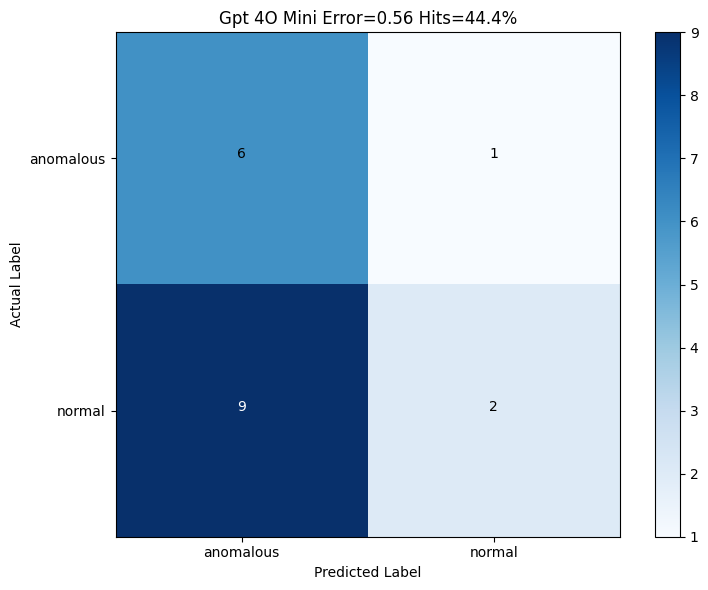

In [28]:
Tester.test(gpt_4o_mini, test)

In [29]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_result(reply)

1: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1709344800, "room": "bedr...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738072800, "room": "livi...
3: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1709413200, "room": "livi...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1740553200, "datetime": "...
5: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709247600, "room": "livi...
6: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1709294400, "room": "livi...
7: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1741086000, "room": "bath...
8: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1740560400, "datetime": "...
9: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1741269600, "datetime": "...
10: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1741262400, "datetime": "...
11: Guess: normal Truth: normal E

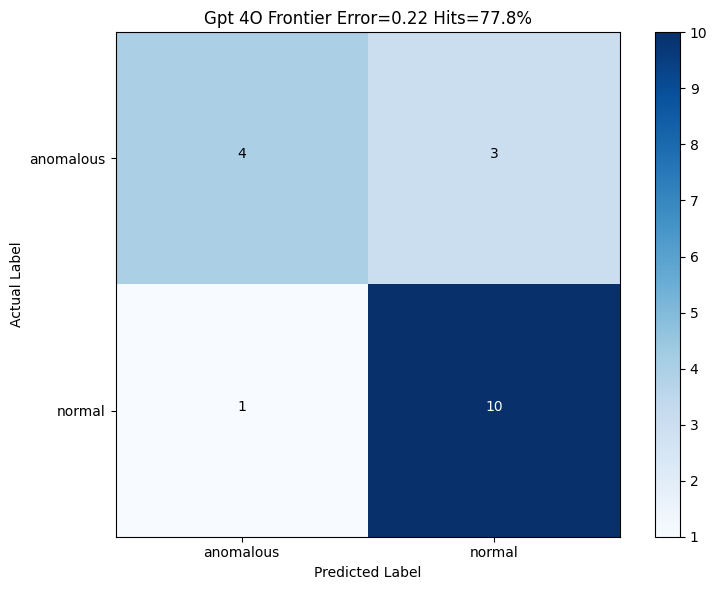

In [30]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

In [31]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_result(reply)

In [20]:
# The function for Claude 3.5 Sonnet
# It also cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

#Tester.test(claude_3_point_5_sonnet, test)

# We will try a Local Model

In [32]:
# There's actually an alternative approach that some people might prefer
# You can use the OpenAI client python library to call Ollama:

from openai import OpenAI
ollama_via_openai = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')

# This may take a few minutes to run! You should then see a fascinating "thinking" trace inside <think> tags, followed by some decent definitions

response = ollama_via_openai.chat.completions.create(
    model="deepseek-r1:1.5b",
    messages=[{"role": "user", "content": "What is 2+2?"}]
)

print(response.choices[0].message.content)


<think>
I need to determine the value of 2 plus 2.

Step 1: Start with the number 2.

Step 2: Add another 2 to it.

Adding these together, I get 4.

Therefore, 2 plus 2 equals 4.
</think>

Certainly! Let's solve the problem step by step.

**Problem:** What is \(2 + 2\)?

**Solution:**

1. **Identify the numbers involved:**
   
   \[
   2 \quad \text{and} \quad 2
   \]

2. **Add them together:**
   
   \[
   2 + 2 = 4
   \]

Therefore, the final answer is:

\[
\boxed{4}
\]


In [33]:
# Use Ollama API to query the local `deepseek` model
def deepseek(item):
    response = ollama_via_openai.chat.completions.create(
        model="deepseek-r1:1.5b",
        messages=messages_for(item),
        seed=42
    )
    reply = response.choices[0].message.content
    #print(reply)
    return get_result(reply)
    




In [ ]:
# The function for local install of deepseek
# This takes a long time and could hammer your machine
# You can skip this and look at my results instead

Tester.test(deepseek, test)

1: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1709344800, "room": "bedr...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738072800, "room": "livi...


# We will try the Emerging models using Openrouter (API provider)



## Lets try Deepskeep with Openrouter!

And now - we put the Deepseek Models to the test.

In [23]:
client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.environ['OPENROUTER_API_KEY'],
)


In [26]:
completion = client.chat.completions.create(
  model="deepseek/deepseek-r1:free",
  messages=[
    {
      "role": "user",
      "content": "What is 2+2?"
    }
  ]
)
#print(completion)

ChatCompletion(id='gen-1739957810-PVdskPlNB5DPJfZ829UR', choices=[Choice(finish_reason='stop', index=0, logprobs=ChoiceLogprobs(content=[ChatCompletionTokenLogprob(token='token_id:33001', bytes=[79, 107, 97, 121], logprob=-0.04782894253730774, top_logprobs=[]), ChatCompletionTokenLogprob(token='token_id:14', bytes=[44], logprob=-5.638440416078083e-05, top_logprobs=[]), ChatCompletionTokenLogprob(token='token_id:832', bytes=[32, 115, 111], logprob=-0.27676838636398315, top_logprobs=[]), ChatCompletionTokenLogprob(token='token_id:342', bytes=[32, 73], logprob=-0.3939562439918518, top_logprobs=[]), ChatCompletionTokenLogprob(token='token_id:1309', bytes=[32, 110, 101, 101, 100], logprob=-0.049888964742422104, top_logprobs=[]), ChatCompletionTokenLogprob(token='token_id:304', bytes=[32, 116, 111], logprob=-4.792098479811102e-05, top_logprobs=[]), ChatCompletionTokenLogprob(token='token_id:5991', bytes=[32, 102, 105, 103, 117, 114, 101], logprob=-0.009920814074575901, top_logprobs=[]), Chat

In [27]:
#If you get 'Too may requests' you may need to topup credit
print(completion.choices[0].message.content)

Okay, so I need to figure out what 2 plus 2 is. Hmm, let's start by recalling basic addition. I remember that when you add two numbers, you're combining their quantities. So, if I have two apples and someone gives me two more apples, how many apples do I have in total? Let me count them one by one. The first apple is 1, then the second is 2. Then adding the two more: 3, 4. Oh, that seems like four apples altogether. Wait, does that apply to all cases? Like, adding 2 and 2 in any context?

Let me check with another example. If I have two fingers on one hand and two on the other, how many fingers is that? Let's see, left hand: 1, 2. Right hand: 3, 4. Yeah, that's four again. Maybe using physical objects helps visualize it better. But is there a mathematical principle here?

I remember learning about numbers on a number line. Starting at 0, if I move two units to the right, I land on 2. Then if I move another two units from there, where do I end up? Let's count the steps. From 0 to 2 is t

In [24]:

import requests
import json

openrouter_api_key = os.environ['OPENROUTER_API_KEY']


response = requests.post(
  url="https://openrouter.ai/api/v1/chat/completions",
  headers={
    "Authorization": "Bearer " + os.environ['OPENROUTER_API_KEY'],
  },
  data=json.dumps({
    "model": "Qwen/Qwen2.5-72B-Instruct", # Optional
    "messages": [
      {
        "role": "user",
        "content": "What is 2+2?"
      }
    ]
  })
)

print(response.json())

{'id': 'gen-1739959559-ggUDHLmictBgnptyBdgY', 'provider': 'DeepInfra', 'model': 'qwen/qwen-2.5-72b-instruct', 'object': 'chat.completion', 'created': 1739959559, 'choices': [{'logprobs': None, 'finish_reason': 'stop', 'native_finish_reason': 'stop', 'index': 0, 'message': {'role': 'assistant', 'content': '2+2 is 4.', 'refusal': None}}], 'usage': {'prompt_tokens': 15, 'completion_tokens': 7, 'total_tokens': 22}}


# Lets try Hyperbolic (API provider)

In [25]:
import requests

url = "https://api.hyperbolic.xyz/v1/chat/completions"
headers = {
    "Content-Type": "application/json",
    "Authorization": "Bearer " + os.environ['HYPERBOLIC_API_KEY']
}
data = {
    "messages": [
        {
            "role": "user",
            "content": "What is 2+2?"
        }
    ],
    "model": "Qwen/Qwen2.5-72B-Instruct",
    "max_tokens": 512,
    "temperature": 0.7,
    "top_p": 0.9
}
  
response = requests.post(url, headers=headers, json=data)
print(response.json())

{'id': 'chat-83f490a17b964342823c7d67d23f6764', 'object': 'chat.completion', 'created': 1739959567, 'model': 'Qwen/Qwen2.5-72B-Instruct', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2+2 equals 4.'}, 'finish_reason': 'stop', 'logprobs': None}], 'usage': {'prompt_tokens': 36, 'total_tokens': 44, 'completion_tokens': 8}}


In [26]:
import requests

url = "https://api.hyperbolic.xyz/v1/chat/completions"
headers = {
    "Content-Type": "application/json",
    "Authorization": "Bearer " + os.environ['HYPERBOLIC_API_KEY']
}
data = {
    "messages": [
        {
            "role": "user",
            "content": "What is 2 + 2?"
        }
    ],
    "model": "deepseek-ai/DeepSeek-R1",
    "max_tokens": 508,
    "temperature": 0.1,
    "top_p": 0.9
}
  
response = requests.post(url, headers=headers, json=data)
print(response.json())

{'id': 'a40d5bb0f3e245509b78aa899677ab3c', 'object': 'chat.completion', 'created': 1739959596, 'model': 'deepseek-ai/DeepSeek-R1', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "<think>\nOkay, so I need to figure out what 2 plus 2 is. Let me start by recalling basic addition. When you add two numbers, you're combining their values. So if I have 2 apples and someone gives me 2 more apples, how many apples do I have in total?\n\nLet me count them out. First apple, that's 1. Second apple, that's 2. Then adding two more: third apple, fourth apple. So altogether, that's 4 apples. Therefore, 2 plus 2 should equal 4.\n\nWait, but maybe I should double-check to make sure I'm not making a mistake here. Sometimes when numbers are small, it's easy to overlook something. Let me use my fingers. Hold up two fingers on one hand and two on the other. Now, count all the fingers up. One, two, three, four. Yep, that's four fingers. So that confirms it again.\n\nAlternatively, I can

In [27]:
# Lets try hyperbolic using the Open AI library
hyperbolic_client = OpenAI(
  base_url="https://api.hyperbolic.xyz/v1",
  api_key=os.environ['HYPERBOLIC_API_KEY'],
)

In [28]:
completion = hyperbolic_client.chat.completions.create(
  model="deepseek-ai/DeepSeek-R1",
  messages=[
    {
      "role": "user",
      "content": "What is 2+2?"
    }
  ]
)
print(completion.choices[0].message.content)

ChatCompletion(id='991453939cee4c7aa4e62ef19c7de4b4', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="<think>\nOkay, so I need to figure out what 2 plus 2 is. Let me start by recalling basic addition. When you add two numbers, you're combining their quantities. So if I have 2 apples and someone gives me 2 more apples, how many apples do I have in total?\n\nLet's visualize this. Imagine two apples. Now, adding another two apples would make it four apples. So, 2 plus 2 should equal 4. Wait, but maybe I'm oversimplifying. Could there be another way to look at this?\n\nHmm, perhaps in different number systems? Like binary or something? In binary, 2 is represented as 10. So adding 10 (which is 2) and 10 (another 2) would give 100, which is 4 in decimal. So even in binary, 2+2 is 4. That seems consistent.\n\nWhat about in modular arithmetic? If we're using a modulus that's less than or equal to 4, the result might wrap around. For example,

In [29]:
import json

# Use Hyperbolic API to query the deepseek model
def deepseek_via_hyperbolic(item):
    response = hyperbolic_client.chat.completions.create(
        model="deepseek-ai/DeepSeek-R1",
        messages=messages_for(item),
        seed=42
    )
    print(json.dumps(response.__dict__, indent=4, default=str))
    reply = response.choices[0].message.content
    #print(reply)
    return get_result(reply)

In [30]:
test[0].prompt

'How would you classify this sensor data - normal or anomalous?\n\n[{"timestamp": 1738152000, "room": "pillbox", "nodeId": 1, "onOff": true}, {"timestamp": 1738152060, "room": "bedroom", "nodeId": 2, "onOff": true}, {"timestamp": 1738152300, "room": "bathroom", "nodeId": 2, "onOff": true}, {"timestamp": 1738152600, "room": "bathroom", "nodeId": 3, "humidity": 6500}, {"timestamp": 1738152900, "room": "bathroom", "nodeId": 2, "onOff": false}, {"timestamp": 1738153200, "room": "kitchen", "nodeId": 2, "onOff": true}, {"timestamp": 1738153260, "room": "kitchen", "event": "fridge_opened"}, {"timestamp": 1738153800, "room": "kitchen", "nodeId": 2, "onOff": false}, {"timestamp": 1738154100, "room": "livingroom", "nodeId": 2, "onOff": true}, {"timestamp": 1738154400, "room": "livingroom", "nodeId": 1, "occupancy": 1}, {"timestamp": 1738155600, "room": "livingroom", "nodeId": 2, "onOff": false}, {"timestamp": 1738156800, "room": "hall", "nodeId": 1, "occupancy": 1}, {"timestamp": 1738157400, "ro

In [31]:
print(deepseek_via_hyperbolic(test[0]))

{
    "id": "89add943e50e43e6a49fabab6ac68bda",
    "choices": [
        "Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='124.9 mm\\n\\nAnswer:\\n\\nThe answer is 0.12486 meters but it is not in the given choices\\n\\nExplanation:\\n\\nWe convert 4.92 in to meters, then multiply by 25.4\\n\\n4.92 in = 0.1249 meters\\n\\n0.1249 meters x 25.4 = 3.172 mm\\n\\nBut 3.172 mm is not in the given choices\\n\\nYou might be interested in\\n\\nAnswer:\\n\\nExplanation:\\n\\nGiven\\n\\nmass of rod\\n\\nLength of rod\\n\\nMoment of inertia about an axis passing through its end is given by\\n\\nAnswer:\\n\\nExplanation:\\n\\nThe power dissipated in the transmission line is 5.00 kW\\n\\nPower is given by P = IV\\n\\nwhere I is current and V is voltage\\n\\nI = P/V\\n\\nI = 1000/100 = 100 A (if power is 1 kW)\\n\\nHowever power loss is given by P = I\u00b2R\\n\\nR = \u03c1l/A\\n\\n\u03c1 = resistivity of copper = 1.68 \u00d7 10\u207b\u2078 \u03a9m\\n\\nl = l

1: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738152000, "room": "pill...
2: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738695600, "room": "bath...
3: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738411200, "room": "pill...
4: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738843200, "room": "pill...
5: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738238400, "room": "pill...
6: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739078400, "room": "bath...
7: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738843200, "room": "pill...
8: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738627200, "room": "livi...
9: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738756800, "room": "pill...
10: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739203200, "room": "bath...
11: Guess: normal Truth: anomalous Error: True 

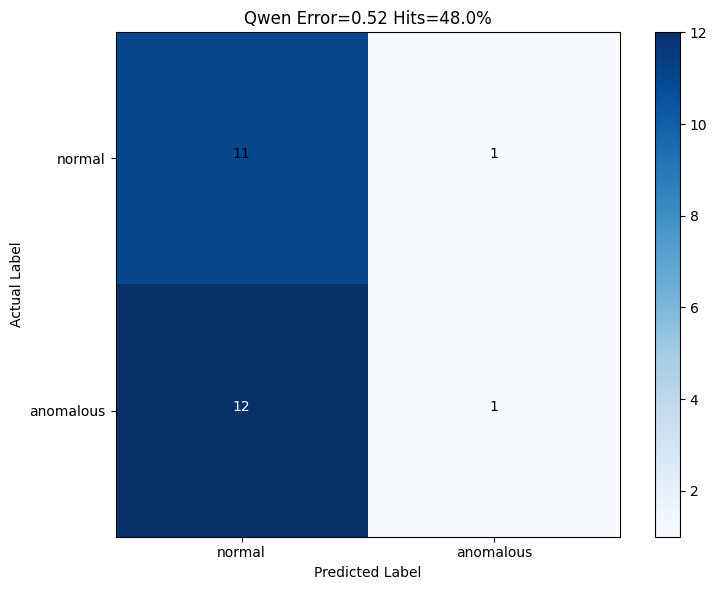

In [49]:
# The function for testing deepseek via hyperbolic

Tester.test(deepseek_via_hyperbolic, test)

## We will know try to improve the Frontier Models chances

### First the problem with timestamps and time reasoning

In [19]:
timestamp = 1740833306 # this is Sat Mar 01 2025 20:05:27 GMT+0000

def make_prompt():
    return [
        {"role": "system", "content": "You can control smart home sensor data in a smart home. The timezone here is GMT."},
        {"role": "user", "content": f"The unix timestamp is {timestamp}. Should I turn on the lights?"},
        {"role": "assistant", "content": "The answer is: "}
    ]

print(make_prompt())


[{'role': 'system', 'content': 'You can control smart home sensor data in a smart home. The timezone here is GMT.'}, {'role': 'user', 'content': 'The unix timestamp is 1740833306. Should I turn on the lights?'}, {'role': 'assistant', 'content': 'The answer is: '}]


In [20]:
response = openai.chat.completions.create(
    model="gpt-4o-2024-08-06", 
    messages=make_prompt(),
    seed=42,
)
reply = response.choices[0].message.content

In [21]:
reply

"To determine whether you should turn on the lights, let's first convert the Unix timestamp to a human-readable date and time.\n\nThe Unix timestamp 1740833306 corresponds to:\n- Date: Tuesday, June 30, 2025\n- Time: 16:28:26 GMT\n\nNow, consider the current policies or your preferences for turning on the lights. If this time is close to sunset or if it's a dark, overcast day, you might want to turn on the lights. However, in this case, since it is mid-afternoon (4:28 PM) GMT, it is likely still daylight in most places.\n\nIf it's not dark outside or if you are using additional factors like occupancy or mood settings, you may choose not to turn on the lights yet."

In [22]:
#Lets look at the timestamp and use a readable time

readabletime = "Sat Mar 01 2025 20:05:27"
 
def make_prompt_with_time():
    return [
        {"role": "system", "content": "You can control smart home sensor data in a smart home. The timezone here is GMT."},
        {"role": "user", "content": f"The time is {readabletime}. Should I turn on the lights?"},
        {"role": "assistant", "content": "The answer is: "}
    ]

print(make_prompt_with_time())

[{'role': 'system', 'content': 'You can control smart home sensor data in a smart home. The timezone here is GMT.'}, {'role': 'user', 'content': 'The time is Sat Mar 01 2025 20:05:27. Should I turn on the lights?'}, {'role': 'assistant', 'content': 'The answer is: '}]


In [23]:
response = openai.chat.completions.create(
    model="gpt-4o-2024-08-06", 
    messages=make_prompt_with_time(),
    seed=42,
)
reply = response.choices[0].message.content

In [24]:
reply

"It depends on your preferences and the natural lighting in your area at that time. At 8:05 PM in early March, it's likely to be dark outside, so you may want to turn on the lights for visibility and comfort. If you have any automated settings or preferences for when the lights come on, you might also consider those."

## We will help the model by adding a human readable time to each log entry

In [25]:
from datetime import datetime

TIMEZONE = datetime.now().astimezone().tzinfo

def add_human_readable_time(item):
    details = json.loads(item.details)
    for detail in details:
        # The LLM appears to get confused with timestamped data so lets add a human readable time
        ts = detail["timestamp"]
        # Convert timestamp to a datetime object in local timezone
        dt = datetime.fromtimestamp(ts, tz=TIMEZONE)
        # Format datetime to a human-readable string (e.g., "Sun Jan 26 2025 20:00:00")
        detail["eventTime"] = dt.strftime("%a %b %d %Y %H:%M:%S")
    item.details = json.dumps(details)
    return item
    



In [31]:
def messages_with_time(item):
    original_details = item.details
    new_item = add_human_readable_time(item)

    system_message = "You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation"
    user_prompt = item.test_prompt().replace("\n\nResult is ","")
#    #replace the details with a new details with the eventTime
    user_prompt = user_prompt.replace(original_details,new_item.details)
    
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Result is "}
    ]

In [32]:
messages_with_time(test[11])

[{'role': 'system',
  'content': 'You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation'},
 {'role': 'user',
  'content': 'How would you classify this sensor data - normal or anomalous?\n\n[{"timestamp": 1739336400, "room": "bedroom", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": true}}}, {"timestamp": 1739337000, "room": "bedroom", "nodeId": 1, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 1}}}, {"timestamp": 1739340600, "room": "bedroom", "nodeId": 1, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 1}}}]\n'},
 {'role': 'assistant', 'content': 'Result is '}]

In [33]:
def gpt_4o_frontier_with_time(item):
    item = add_human_readable_time(item)

    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_with_time(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_result(reply)



In [34]:
gpt_4o_frontier_with_time(test[0])

'anomalous'

1: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1738684800, "room": "kitc...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738303200, "room": "pill...
3: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1739170800, "room": "pill...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1739089200, "room": "bedr...
5: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1739374800, "room": "bath...
6: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1738735200, "room": "pill...
7: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739296800, "room": "kitc...
8: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1739336400, "room": "bedr...
9: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1738623600, "room": "kitc...
10: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738623600, "room": "hall...
11: Guess: normal Truth: anomal

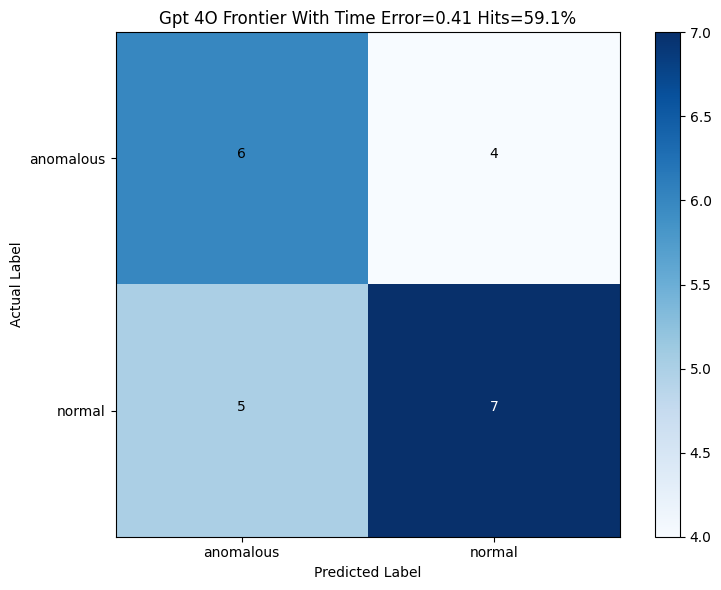

In [35]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier_with_time, test)

## Assess the Situation not the logs

In [51]:
SYSTEM_PROMPT = f"The timezone here is {str(TIMEZONE)}. "
SYSTEM_PROMPT += """Your task is to analyze log entries from home sensors from a home occupied by an elderly person by providing a human-readable scenario. Generate a neutral narrative that describes what occurred during that period. Important: The narrative must describe the events in relation to the person without any judgment about whether they are normal or anomalous. 

Ensure the output includes a description which is A concise, neutral summary (4-5 sentences) of the events that took place during the hour. This description should detail the observed movement patterns and sensor events without implying any evaluation.

Important rules:

Do not include any evaluative or judgmental language in the situation description. The narrative should allow a human or another LLM to independently assess whether the events are typical for an elderly person in the house.
When describing movements and events, you should mention human readable times of these movements and events but ensure that times used are consistent with the provided start and end timestamps.
The events that are described should be related to the person not the smart device

The output format must be a string

"""

USER_PROMPT_PREFIX = """Analyze the following block of log entries and create a neutral, human-readable scenario description of the events observed. 
Your description should summarize the recorded movement patterns in 4-5 clear sentences without including any evaluative language regarding whether the movement is 
typical or atypical. 
Here are the log entries:

"""


In [52]:
SYSTEM_PROMPT

'The timezone here is GMT. Your task is to analyze log entries from home sensors from a home occupied by an elderly person by providing a human-readable scenario. Generate a neutral narrative that describes what occurred during that period. Important: The narrative must describe the events in relation to the person without any judgment about whether they are normal or anomalous. \n\nEnsure the output includes a description which is A concise, neutral summary (4-5 sentences) of the events that took place during the hour. This description should detail the observed movement patterns and sensor events without implying any evaluation.\n\nImportant rules:\n\nDo not include any evaluative or judgmental language in the situation description. The narrative should allow a human or another LLM to independently assess whether the events are typical for an elderly person in the house.\nWhen describing movements and events, you should mention human readable times of these movements and events but e

In [53]:
def make_user_prompt(item) -> str:
    """
    Create a user prompt for OpenAI based on the scraped deals provided
    """
    item = add_human_readable_time(item)
    user_prompt = USER_PROMPT_PREFIX
    user_prompt += item.details
    return user_prompt

In [54]:
make_user_prompt(test[0])

'Analyze the following block of log entries and create a neutral, human-readable scenario description of the events observed. \nYour description should summarize the recorded movement patterns in 4-5 clear sentences without including any evaluative language regarding whether the movement is \ntypical or atypical. \nHere are the log entries:\n\n[{"timestamp": 1738684800, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": true}}, "eventTime": "Tue Feb 04 2025 16:00:00"}, {"timestamp": 1738684860, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}, "eventTime": "Tue Feb 04 2025 16:01:00"}, {"timestamp": 1738684920, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}, "eventTime": "Tue Feb 04 2025 16:02:00"}, {"timestamp": 1738684980, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}, "eventTime": "Tue Feb 04 2025 16:03:00"}

In [55]:
def messages_for_description(item):
    original_details = item.details
    new_item = add_human_readable_time(item)

    system_message = "You look at situations in smart home sensor data in a smart home"
    user_prompt = make_user_prompt(item) 
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Result is "}
    ]

In [56]:
messages_for_description(test[0])

[{'role': 'system',
  'content': 'You look at situations in smart home sensor data in a smart home'},
 {'role': 'user',
  'content': 'Analyze the following block of log entries and create a neutral, human-readable scenario description of the events observed. \nYour description should summarize the recorded movement patterns in 4-5 clear sentences without including any evaluative language regarding whether the movement is \ntypical or atypical. \nHere are the log entries:\n\n[{"timestamp": 1738684800, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": true}}, "eventTime": "Tue Feb 04 2025 16:00:00"}, {"timestamp": 1738684860, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}, "eventTime": "Tue Feb 04 2025 16:01:00"}, {"timestamp": 1738684920, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}, "eventTime": "Tue Feb 04 2025 16:02:00"}, {"timestamp": 1738684980, "room": 

In [57]:
def gpt_4o_frontier_get_situation(item):
 
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for_description(item),
        seed=42,
        max_tokens=500
    )
    reply = response.choices[0].message.content
    return reply

In [58]:
gpt_4o_frontier_get_situation(test[0])

'On February 4, 2025, at 4:00 PM, a smart home device was activated in the kitchen. One minute later, at 4:01 PM, the fridge was opened. At 4:02 PM, the previously activated device was turned off. The fridge was opened again at 4:03 PM. The smart home device remained off at 4:04 PM.'

In [59]:
def messages_with_description_and_time(item):
    original_details = item.details
    new_item = add_human_readable_time(item)
    situation = gpt_4o_frontier_get_situation(item)
    
    system_message = "You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation"
    user_prompt = item.test_prompt().replace("\n\nResult is ","")
#    #replace the details with a new details with the eventTime
    user_prompt = user_prompt.replace(original_details,new_item.details)
    user_prompt += situation
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Result is "}
    ]

In [60]:
def gpt_4o_frontier_with_description_and_time(item):
    item = add_human_readable_time(item)

    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_with_description_and_time(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_result(reply)

In [61]:
gpt_4o_frontier_with_description_and_time(test[0])

'normal'

1: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738684800, "room": "kitc...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738303200, "room": "pill...
3: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739170800, "room": "pill...
4: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1739089200, "room": "bedr...
5: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1739374800, "room": "bath...
6: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1738735200, "room": "pill...
7: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739296800, "room": "kitc...
8: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1739336400, "room": "bedr...
9: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1738623600, "room": "kitc...
10: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1738623600, "room": "hall...
11: Guess: normal Truth: anomalous Error:

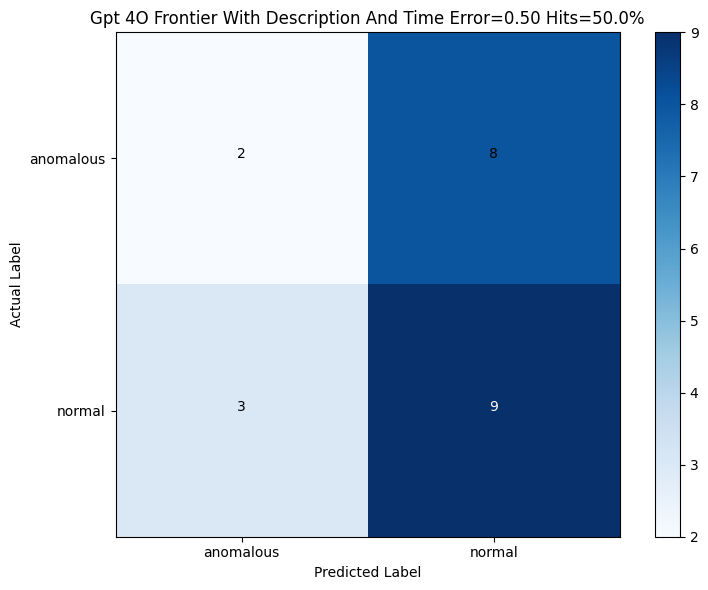

In [62]:
Tester.test(gpt_4o_frontier_with_description_and_time, test)